In [1]:
def reinhard_normalize(im_src, reinhard_dict):
    import histomicstk as htk
    
    target_mu = reinhard_dict['target_mu']
    target_sigma = reinhard_dict['target_sigma']
    return htk.preprocessing.color_normalization.reinhard(im_src, target_mu, target_sigma, src_mu=None, src_sigma=None)

In [11]:
from abc import ABCMeta, abstractmethod

class ImageReader:
    __metaclass__ = ABCMeta

    def __init__(self, path, frame_cache_dict):
        self.path = path
        if frame_cache_dict is None:
            self.n_frames_cached = None
        else:
            self.n_frames_cached = frame_cache_dict[self.basename()]
        
    @staticmethod
    def open(filename, type, frame_cache_dict=None, reinhard_norm_dict=None):
        if type == 'png':
            return PngImageReader(filename, frame_cache_dict, reinhard_norm_dict)
        elif type == 'tiff':
            return TifImageReader(filename, frame_cache_dict, reinhard_norm_dict)
        else:
            raise Exception('Unknown type %s' % type)
    @staticmethod
    def findnth(haystack, needle, n):
        """Find Nth occurance of string in another string"""
        parts= haystack.split(needle, n+1)
        if len(parts)<=n+1:
            return -1
        return len(haystack)-len(parts[-1])-len(needle)
    
    @abstractmethod
    def n_frames(self):
        pass
    
    @abstractmethod
    def load_frame(self, index):
        pass
    
    def load_frames(self, indexes):
        return [self.load_frame(index) for index in indexes]
    
    @abstractmethod
    def load_frame_meta(self, index):
        pass
    
    @abstractmethod
    def delete(self):
        pass
    
    def exists(self):
        from pathlib2 import Path
        return Path(self.path).exists()
    
    def basename(self):
        import os
        return os.path.basename(self.path) # Different for TIF & PNG
    
    def barcode(self):
        # different for TCGA and GTEX
        filename = self.basename()
        is_tcga = 'TCGA' in filename
        is_gtex = 'GTEX' in filename
        if is_tcga:
            return filename[:ImageReader.findnth(filename,'-',2)]
        if is_gtex:
            return filename[:ImageReader.findnth(filename,'-',1)]
        raise

class PngImageReader(ImageReader):
    def __init__(self, path, frame_cache_dict=None, reinhard_norm_dict=None):
        super(PngImageReader, self).__init__(path, frame_cache_dict)
        
        self.reinhard_norm_dict = reinhard_norm_dict
    
    def n_frames(self):
        import os
        
        if self.n_frames_cached:
            return self.n_frames_cached
        
        return len(os.listdir(self.path))
    
    def load_frame(self, index):
        #from PIL import Image
        import numpy as np
        import skimage.io
        try:
            img_path = self.path + '/' + str(index)+'.png'
            img = skimage.io.imread(img_path)[:, :, :3]
            if self.reinhard_norm_dict:
                img = reinhard_normalize(img, self.reinhard_norm_dict)
            return img.astype(float)
            #img = Image.open(img_path)
            #return np.asarray(img.convert('RGB')).astype(float)
        except IOError:
            print self.path
            raise IndexError()
    
    def load_frame_meta(self, index):
        from PIL import Image
        import numpy as np
        try:
            img = Image.open(self.path + '/' + str(index)+'.png')
            return img.info
        except IOError:
            print self.path, index
            raise IndexError()
    
    def delete(self):
        import shutil
        shutil.rmtree(self.path)
            
            
class TifImageReader(ImageReader):
    #TODO: Cache n_frames in file
    def __init__(self, path, frame_cache_dict=None, reinhard_norm_dict=None):
        super(TifImageReader, self).__init__(path, frame_cache_dict)
    
        assert reinhard_norm_dict == None
    
        from expiringdict import ExpiringDict
        self.cache = ExpiringDict(max_len=1, max_age_seconds=5)
    
    def __load(self):
        img = self.cache.get('img', None)
        if img == None:
            from PIL import Image
            img = Image.open(self.path)
            self.cache['img'] = img
        return img
    
    def n_frames(self):
        
        if self.n_frames_cached:
            return self.n_frames_cached
        
        return self.__load().n_frames
    
    def load_frame(self, index):
        import numpy as np
        
        img = self.__load()
        img.seek(index)
        return np.asarray(img.convert('RGB')).astype(float)
    
    def load_frame_meta(self, index):
        import ast

        img = self.__load()
        img.seek(index)
        tif_info = ast.literal_eval(img.tag[270][0])
        return tif_info
    
    def delete(self):
        import os
        os.remove(self.path)

        
class FrameCountCache:
    """
       Calculates frames count per image.
       This is a costly operation (for tif), cache it.
    """
    def __init__(self, cache_file, image_readers):
        import pickle
        try:
            frames_dict = pickle.load(open(cache_file, "rb"))
        except (OSError, IOError) as e:
            frames_dict = {}
        for reader in image_readers:
            img_name = reader.basename()
            if img_name not in frames_dict:
                try:
                    frames_dict[img_name] = reader.n_frames()
                except:
                    reader.delete()
                    print 'Could not load image, DELETED, restart after job is done: %s' % img_name
        pickle.dump(frames_dict, open(cache_file, "wb+"), pickle.HIGHEST_PROTOCOL)
        self.dict = frames_dict

In [13]:
# Test Png

def pngTest(show=False):
    import matplotlib.pyplot as plt
    
    img = ImageReader.open('/var/shared/hist_project/tmp/GTEX-1I1HK-0725_1.0', type='png')
    #img = PngImageReader('/var/shared/hist_project/tmp/GTEX-1I1HK-0725_1.0')
    print img.n_frames()
    frame = img.load_frame(50)
    if show:
        plt.imshow(frame/255.0)

#%time pngTest(show=True)

In [3]:
# Test Tif

def tifTest(show=False):
    import matplotlib.pyplot as plt

    #img = TifImageReader('/var/shared/hist_project/tmp/GTEX-1I1HK-0725_1.0.tif')
    img = ImageReader.open('/var/shared/hist_project/tmp/GTEX-1I1HK-0725_1.0.tif', type='tiff')
    print img.n_frames()
    frame = img.load_frame(50)
    if show:
        plt.imshow(frame/255.0)

#%time tifTest(show=False)

In [4]:
# Test dict

def dictTest():
    img = ImageReader.open('/var/shared/hist_project/tmp/GTEX-1I1HK-0725_1.0', type='png')
    frames_dict = FrameCountCache([img]).dict
    return frames_dict[img.basename()]
    #return img.n_frames() # Actually quicker for PNG!

#%time dictTest()

In [89]:
import numpy as np

class GroupReader(object):
    __metaclass__ = ABCMeta

    def __init__(self, img_readers):
        import numpy as np
        self.img_readers = img_readers
        self.n_frames_cached = np.array([img.n_frames() for img in self.img_readers])
    
        total_so_far = 0
        self.n_frame_skip = []
        for img_n_frames in self.n_frames_cached:
            self.n_frame_skip.append(total_so_far)
            total_so_far += img_n_frames
        self.n_frame_skip = np.array(self.n_frame_skip)
        
    def debug_info(self):
        print [r.path for r in self.img_readers]
        print self.n_frame_skip
        
    def __len__(self):
        return self.n_frames()
        
    def n_frames(self):
        return sum(self.n_frames_cached)
    
    def find_img_reader(self,index, low=None, up=None):
        # binary search
        #print 'call', index, low, up,
        
        if not low:
            low = 0
        if not up:
            up = len(self.n_frame_skip)
        while up!=low:
            midIndex = int((low+up) / 2)
            midVal = self.n_frame_skip[midIndex]
            if index >= midVal:
                if (midIndex == len(self.n_frame_skip)-1) or (self.n_frame_skip[midIndex+1] > index):
                    #print ' return ', midIndex
                    return midIndex
                low = midIndex
            else:
                up = midIndex
        print 'OOps!'
        self.debug_info()
        print index
    def find_img_reader_index(self, img_reader):
        for i, reader in enumerate(self.img_readers):
            if reader == img_reader:
                return i
    def reader_indexes_to_new_indexes(self, img_reader, indexes):
        readerIndex = self.find_img_reader_index(img_reader)
        return [(self.n_frame_skip[readerIndex]+i) for i in indexes] 
    def load_frame(self, index, low=None, up=None):
        readerIndex = self.find_img_reader(index, low=None, up=None)

        img_reader, new_index = self.img_readers[readerIndex], index - self.n_frame_skip[readerIndex]
        try:
            return img_reader.load_frame(new_index)
        except Exception as e:
            print e
            print 'OOps2!'
            self.debug_info()
            print index
    def load_frames(self, indexes):
        #assert type(indexes)==np.ndarray
        if len(indexes) > 10 and len(self.img_readers) > 100:
            indexes.sort()
            indexesNew = np.zeros(len(indexes), dtype=np.int32)
            indexesNew[0] = self.find_img_reader(indexes[0], low=None, up=None)
            indexesNew[-1] = self.find_img_reader(indexes[-1], low=indexesNew[0], up=None)
            for i in range(1, len(indexes)-1):
                indexesNew[i] = self.find_img_reader(indexes[i], low=indexesNew[i-1], up=indexesNew[-1]+1)
            #print indexesNew
            return [self.img_readers[readerIndex].load_frame(index-self.n_frame_skip[readerIndex]) for index,readerIndex in zip(indexes, indexesNew)]
        else:
            return [self.load_frame(index) for index in indexes]
    
    def load_frame_meta(self, index):
        
        img_reader, new_index = self.find_img_reader(index)
        return img_reader.load_frame_meta(new_index)

class PatientReader(GroupReader):
    def __init__(self, img_readers):
        super(PatientReader, self).__init__(img_readers)
        
        barcode = self.img_readers[0].barcode()
        for img_reader in self.img_readers:
            assert barcode == img_reader.barcode()
        self.barcode_cached = barcode
        
    def debug_info(self):
        super(PatientReader, self).debug_info()
        print self.barcode()
        
    def barcode(self):
        return self.barcode_cached

388 776 776
0
0
1
1
['/var/shared/hist_project/Data/Level2/TCGA/TCGA-EL-A4JW-11A-01-TSA.0A0D590D-1F96-4CA6-BCC3-B057847A32D1', '/var/shared/hist_project/Data/Level2/TCGA/TCGA-EL-A4JW-11A-01-TSA.0A0D590D-1F96-4CA6-BCC3-B057847A32D1']
[  0 388]
TCGA-EL-A4JW
CPU times: user 88 ms, sys: 0 ns, total: 88 ms
Wall time: 87.4 ms


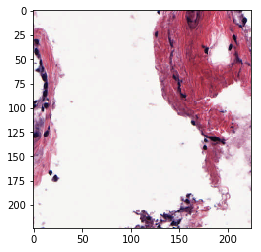

In [90]:
# Test Patient

def patientTest(show=False):
    import matplotlib.pyplot as plt
    
    img = ImageReader.open('/var/shared/hist_project/Data/Level2/TCGA/TCGA-EL-A4JW-11A-01-TSA.0A0D590D-1F96-4CA6-BCC3-B057847A32D1', type='png')
    img2 = ImageReader.open('/var/shared/hist_project/Data/Level2/TCGA/TCGA-EL-A4JW-11A-01-TSA.0A0D590D-1F96-4CA6-BCC3-B057847A32D1', type='png')
    patient = PatientReader([img, img2])
    print img.n_frames(), patient.n_frames(), len(patient)
    for i in [0,387,388,775]:
        frame = patient.load_frame(i)
        print patient.find_img_reader(i)
    frame = patient.load_frames(np.array([0,387,388,775]))[-1]
    patient.debug_info()
    if show:
        plt.imshow(frame/255.0)

#%time patientTest(show=True)